In [1]:
import functools
import operator
from IPython.display import Image, display
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain.agents import (
    AgentExecutor,
    create_openai_tools_agent,
)
from IPython.display import Image, display
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
)
from langgraph.graph import END, START, StateGraph
from langchain_core.messages import BaseMessage, HumanMessage

from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

from langchain_community.tools.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

from langgraph.checkpoint.memory import MemorySaver
from utils.tools.googleCalender import CreateGoogleCalendarEvent
from utils.tools.indetity import identity
from utils.prompt import (
    COMPARISON_PROMPT,
    COLOR_TREND_PROMPT,
    GREETING_PROMPT,
    PRECHAT_PROMPT,
    FEEDBACK_PROMPT,
    SCHEDULER_PROMPT,
    SYSTEM_PROMPT,
    FALLBACK_PROMPT,
)

memory = MemorySaver()

In [2]:
class ComparisonVariables(BaseModel):
    brand: str = Field(description="brand name of the product", max_length=20)
    industry: str = Field(description="industry of the product")
    year: int = Field(description="Year of the product information", ge=2000)


class ColorTrendVariables(BaseModel):
    brand: str = Field(description="brand name of the product", max_length=20)
    start_year: int = Field(description="Starting year of the product information")
    end_year: int = Field(description="Ending year of the product information")


class PrechatVariables(BaseModel):
    full_name: str = Field(description="Full name of the user", max_length=20)
    mobile_number: int = Field(
        description="Mobile Number of the user must be of 10 digits.",
        max_length=10,
        min_length=10,
    )
    email_id: str = Field(description="mail ID of the user", max_length=20)


class GetEventsSchema(BaseModel):
    start_datetime: str = Field(
        description=(
            "The start datetime for the event in the following format: "
            'YYYY-MM-DDTHH:MM:SS, where "T" separates the date and time.'
        )
    )
    end_datetime: str = Field(
        description=(
            "The end datetime for the event in the following format: "
            'YYYY-MM-DDTHH:MM:SS, where "T" separates the date and time.'
        )
    )
    agenda: str
    user_email: str

    timezone: str = Field(
        default="Asia/Kolkata",
    )

In [3]:
credentials = get_gmail_credentials(
    token_file="../token.json",
    scopes=["https://www.googleapis.com/auth/calendar"],
    client_secrets_file="credentials.json",
)

calendar_service = build_resource_service(
    credentials=credentials, service_name="calendar", service_version="v3"
)

createeventtool = CreateGoogleCalendarEvent.from_api_resource(calendar_service)

In [4]:
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [5]:
def create_agent(llm, tools: list, system_prompt):

    agent = create_openai_tools_agent(llm, tools, system_prompt)
    executor = AgentExecutor(agent=agent, tools=tools)

    return executor

In [6]:
comparison_parser = JsonOutputParser(pydantic_object=ComparisonVariables)

In [7]:
comparison_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            COMPARISON_PROMPT,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
).partial(format_instructions=comparison_parser.get_format_instructions())

In [8]:
comparison = create_agent(
    llm=llm, tools=[identity], system_prompt=comparison_prompt_template
)

In [9]:
coolortrend_parser = JsonOutputParser(pydantic_object=ColorTrendVariables)

trend_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            COLOR_TREND_PROMPT,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
).partial(format_instructions=coolortrend_parser.get_format_instructions())

colortrend = create_agent(llm, [identity], trend_prompt_template)

In [10]:
colortrend.invoke(
    {
        "messages": [
            HumanMessage(
                content="What color schemes has Audi used in their cars in the past five years?",
            )
        ]
    }
)

{'messages': [HumanMessage(content='What color schemes has Audi used in their cars in the past five years?')],
 'output': '{"brand": "Audi", "start_year": 2017, "end_year": 2022} FINISH\n{"properties": {"brand": {"description": "brand name of the product", "maxLength": 20, "title": "Brand", "type": "string"}, "start_year": {"description": "Starting year of the product information", "title": "Start Year", "type": "integer"}, "end_year": {"description": "Ending year of the product information", "title": "End Year", "type": "integer"}}, "required": ["brand", "start_year", "end_year"]}'}

In [11]:
greet_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            GREETING_PROMPT,
        ),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)
greet_agent = create_agent(llm, [identity], greet_prompt_template)

In [12]:
prechat_parser = JsonOutputParser(pydantic_object=PrechatVariables)


prechat_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            PRECHAT_PROMPT,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
).partial(format_instructions=prechat_parser.get_format_instructions())

prechat_agent = create_agent(llm, [identity], prechat_prompt_template)

In [13]:
# prechat_agent.invoke(
#     {
#         "messages": [
#             HumanMessage(
#                 content="Hello I am Rohan and this is my contact no: 1024585251",
#             )
#         ]
#     }
# )

In [14]:
feedback_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            FEEDBACK_PROMPT,
        ),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)
feedback_agent = create_agent(llm, [identity], feedback_prompt_template)

In [15]:
# feedback_agent.invoke(
#     {
#         "messages": [
#             HumanMessage(
#                 content="I'm done with my questions",
#             )
#         ]
#     }
# )

In [16]:
scheduler_parser = JsonOutputParser(pydantic_object=GetEventsSchema)

scheduler_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            SCHEDULER_PROMPT,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ],
).partial(
    format_instructions=scheduler_parser.get_format_instructions(),
)

scheduler_agent = create_agent(
    llm=llm,
    tools=[createeventtool, identity],
    system_prompt=scheduler_prompt_template,

)


In [17]:
fallback_prompt_template = ChatPromptTemplate.from_messages(
[
    (
        "system",
        FALLBACK_PROMPT,
        
    ),
    # MessagesPlaceholder(variable_name="messages"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
],
)

fallback_agent = create_agent(
    llm=llm,
    tools=[identity],
    system_prompt=fallback_prompt_template,
)


In [17]:
fallback_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            FALLBACK_PROMPT,
        ),
        # MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ],
)

fallback_agent = create_agent(
    llm=llm,
    tools=[identity],
    system_prompt=fallback_prompt_template,
)

In [18]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [19]:
members = [
    "greet_agent",
    "prechat_agent",
    "comparison",
    "colortrend",
    "scheduler_agent",
    "fallback_agent",
    # "feedback_agent",
]


options = members

function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYSTEM_PROMPT),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above , who should act next?"
            "Or should we FINISH? Select one of : {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(temperature=0)
# llm = ChatGroq(model="llama3-70b-8192")

supervisor_chain = (
    prompt
    | llm.bind_functions(
        functions=[function_def],
        function_call="route",
    )
    | JsonOutputFunctionsParser()
)

In [20]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

    next: str

In [21]:
comparison_node = functools.partial(agent_node, agent=comparison, name="comparison")

colortrend_node = functools.partial(agent_node, agent=colortrend, name="colortrend")

greeting_node = functools.partial(agent_node, agent=greet_agent, name="greet_agent")

prechat_node = functools.partial(agent_node, agent=prechat_agent, name="prechat_agent")

feedback_node = functools.partial(
    agent_node, agent=feedback_agent, name="feedback_agent"
)

scheduler_node = functools.partial(
    agent_node, agent=scheduler_agent, name="scheduler_agent"
)

fallback_node = functools.partial(
    agent_node,agent = fallback_agent, name = "fallback_agent"
)

In [22]:
workflow = StateGraph(AgentState)
# workflow.add_node("comparison", comparison_node)
# workflow.add_node("colortrend", colortrend_node)
workflow.add_node("greet_agent", greeting_node)
workflow.add_node("supervisor", supervisor_chain)
workflow.add_node("prechat_agent", prechat_node)
# workflow.add_node("feedback_agent", feedback_node)
workflow.add_node("scheduler_agent", scheduler_node)
workflow.add_node("fallback_agent", fallback_node)

for member in members:
    workflow.add_edge(member, END)

# workflow.add_conditional_edges("supervisor",{"comparison":"comparison"})

workflow.add_edge("greet_agent", "prechat_agent")
# workflow.add_edge("prechat_agent", "supervisor")


conditional_map = {k: k for k in members}
# new_map = {k: k for k in ["prechat_agent"]}
# workflow.add_conditional_edges("greet_agent",lambda x: x["next"],new_map)
# conditional_map["greet_agent"] = "prechat_agent"
# workflow.add_conditional_edges("supervisor", lambda x: "FINISH" if any("FINISH" in msg.content or "finish" in msg.content for msg in x["messages"]) else x["next"], conditional_map)

workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# map)
workflow.add_edge(START, "supervisor")

graph = workflow.compile(checkpointer=memory)

{'greet_agent': 'greet_agent', 'prechat_agent': 'prechat_agent', 'comparison': 'comparison', 'colortrend': 'colortrend', 'schedular_agent': 'schedular_agent', 'fallback_agent': 'fallback_agent'}


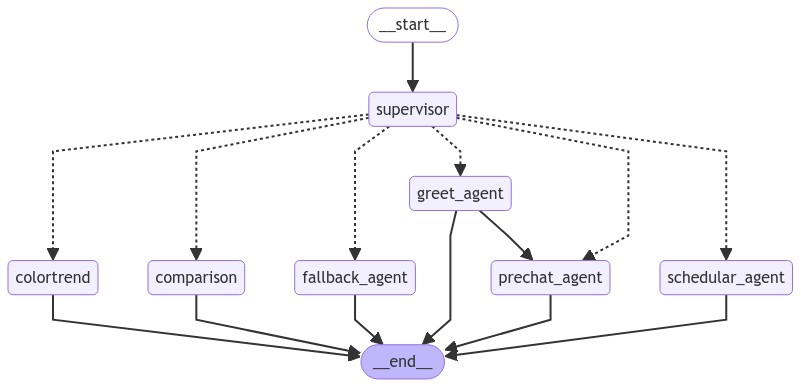

In [23]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [24]:
config = {"configurable": {"thread_id": "1","recurstion_limit": 5}}

In [29]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for s in graph.stream(
        {"messages": [HumanMessage(content=user_input)]}, config
    ):
        # if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'greet_agent'}}
----
{'greet_agent': {'messages': [HumanMessage(content="Hello! Welcome! I'm here to help with questions about color trends, brand comparisons, and more. What are you looking for today?", name='greet_agent')]}}
----
{'prechat_agent': {'messages': [HumanMessage(content='Thank you for providing your information, Rohan Banda. How can I assist you today?', name='prechat_agent')]}}
----
{'supervisor': {'next': 'fallback_agent'}}
----
{'fallback_agent': {'messages': [HumanMessage(content='Please ask a question related to your color trends, brand comparison.', name='fallback_agent')]}}
----
{'supervisor': {'next': 'fallback_agent'}}
----
{'fallback_agent': {'messages': [HumanMessage(content='Please ask a question related to your color trends,brand comparison.', name='fallback_agent')]}}
----
Goodbye!
